# Steady-State Multiplicity in CSTRs

## Introduction

Operation in a continuous stirred tank reactor (CSTR) can lead to complex dynamic behavior in systems that are: (i) strongly exothermal (e.g., chain-growth polymerizations and polyadditions), (ii) auto-accelerated (e.g., gel effect), or (iii) involve nucleation (e.g., emulsion polymerization). 

In this notebook, we address the case of auto-acceleration, based on the work from [Schmidt & Ray (1981)]. Consider a radical homopolymerization carried out in a CSTR at a given temperature (no energy balance effects). Under steady-state operation, the material balances for the initiator and monomer are:

\begin{align*}
0 &= \frac{1}{\tau} \left([I]_{in} - (1+\epsilon)[I]\right) - k_d [I] \\
0 &= \frac{1}{\tau} \left([M]_{in} - (1+\epsilon)[M]\right) - k_p [R^\cdot] [M]
\end{align*}

where $\tau$ is the average residence time based on inlet conditions, and $\epsilon=(\rho_{in}-\rho)/\rho$ is the expansion factor, which accounts for density changes between the inlet and the outlet. Using the Quasi-Steady State Approximation (QSSA) for the radicals, the total radical concentration $[R^\cdot]$ can be expressed in terms of known quantities:   

$$ [R^\cdot] = \sqrt{ \frac{f k_d [I]}{k_t} } $$

Under diluted conditions, $k_t \approx k_{t0}$ and $k_p \approx k_{p0}$ are practically independent of the conversion. As a result, the monomer balance has a unique (and explicit) solution, given by:

$$ [I] = \frac{[I]_{in}}{1 + \epsilon + k_d \tau} $$

$$ [M] = \frac{[M]_{in}}{1 + \epsilon + k_p \sqrt{ \frac{f k_d [I]}{k_t} }  \tau} $$

However, as polymer concentration increases, diffusional limitations start to kick in. The mobility of the radical chains and even that of small molecules decreases, reducing the effective rates of termination and propagation relative to their high-dilution values. These effects are called, respectivelly, gel effect ($k_t$) and glass effect ($k_p$). For the radical polymerization of methyl methacrylate in ethyl acetate, these diffusional limitations can be estimated using the following free-volume correlations: 

$$
g_p = \left\{
\begin{matrix}
1 &  V_f > 0.05 \\
7.1\times 10^{-5}\exp(171.53 V_f) & V_f \le 0.05  \\
\end{matrix}
\right. 
$$

$$
g_t = \left\{
\begin{matrix}
0.10575 \exp(17.15V_f -0.01715(T-273.15)) &  V_f > V_{ft} \\
2.3\times 10^{-6}\exp(75 V_f) & V_f \le V_{ft}
\end{matrix}
\right. 
$$

$$ V_{ft} = 0.1856 - 2.965 \times 10^{-4} (T - 273.15) $$

Here, $g_p=k_p/k_{p0}$, $g_t=k_t/k_{t0}$, and $V_f$ is the total free volume of the reaction mixture, which is the sum of the contributions of each species (monomer, solvent and polymer):

$$ V_f = \phi_P V_{f,P} + \phi_M V_{f,M} + \phi_S V_{f,S} $$

$$ V_{f,i} = 0.025 + \alpha_i (T - T_{g,i}) $$

where $\phi_i$ denotes the volume fraction of species $i$. 

At sufficiently high monomer concentrations, $k_t$ decreases significantly with conversion, resulting in a net acceleration of the polymerization rate as conversion increases. This non-linear dependency leads to the existence of multiple solutions.

**Note**: The gel and glass effect correlations presented above depend only on composition and temperature, not on polymer molar mass. This is a specific case, rather than a general rule.

[Notebook 5]: 5_radical_polymerization.ipynb
[Schmidt & Ray (1981)]: https://doi.org/10.1016/0009-2509(81)80174-1

## Numerical Solution

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import root_scalar

### Model Parameters

Let's begin by gathering all the model parameters. All values are taken from [Schmidt & Ray (1981)].

[Schmidt & Ray (1981)]: https://doi.org/10.1016/0009-2509(81)80174-1

In [2]:
# I: benzoyl peroxide
# M: MMA
# P: PMMA
# S: ethyl acetate

params = {
    'MW': {
        'I': 0.242,  # kg/mol
        'M': 0.100,  # kg/mol
        'S': 0.088,  # kg/mol
    },
    'rho': {
        'M': 0.94,  # kg/L
        'S': 0.90,  # kg/L
        'P': 1.20,  # kg/L
    },
    'Tg': {
        'M': 167.,  # K
        'S': 181.,  # K
        'P': 387.,  # K
    },
    'alpha': {
        'M': 1e-3,   # 1/K
        'S': 1e-3,   # 1/K
        'P': 4.8e-4, # 1/K
    },
    'kinetics': {
        'f': 0.5,
        'kd': {
            'k0': 1.7e14,   # 1/s
            'E': 30e3*4.2,  # J/mol
            'T0': np.inf    # °C
        },
        'kp0': {
            'k0': 4.9e5,     # L/(mol.s)
            'E': 4.35e3*4.2, # J/mol
            'T0': np.inf     # °C
        },
        'kt0': {
            'k0': 0.5*9.8e7, # L/(mol.s)
            'E': 701*4.2,    # J/mol
            'T0': np.inf     # °C
        },
    },
}

### Gel and Glass Effects

Next, we implement a function to evaluate the diffusion effects as a function of mixture composition and temperature.

In [3]:
@np.vectorize
def diffusional_limitations(X_M: float, w_S: float, T: float, params: dict
                            ) -> tuple[float, float]:
    """Calculate diffusional limitations on kp and kt.

    Parameters
    ----------
    X_M : float
        Monomer conversion.
    w_S : float
        Solvent mass fraction.
    T : float
        Temperature (°C).
    params : dict
        Model parameters.

    Returns
    -------
    tuple[float, float]
        gp=kp/kp0 and gt=kt/kt0.
    """

    # Free volume parameters
    Tg = np.empty(3)
    alpha = np.empty(3)
    rho = np.empty(3)
    for idx, name in enumerate(['M', 'S', 'P']):
        Tg[idx] = params['Tg'][name]
        alpha[idx] = params['alpha'][name]
        rho[idx] = params['rho'][name]

    # Species mass fractions
    w_M = (1 - w_S)*(1 - X_M)
    w_P = 1 - w_S - w_M
    w = np.array([w_M, w_S, w_P])

    # Species volume fractions
    phi = w/rho
    phi /= phi.sum()

    # Free volume of the reaction mixture
    TK = T + 273.15
    vf = 0.025 + alpha*(TK - Tg)
    Vf = np.dot(vf, phi)

    # Glass effect, kp
    if Vf > 0.05:
        gp = 1.0
    else:
        gp = 7.1e-5 * np.exp(171.53*Vf)

    # Gel effect, kt
    Vft = 0.1856 - 2.965e-4 * (TK - 273.15)
    if Vf > Vft:
        gt = 0.10575*np.exp(17.15*Vf - 0.01715*(TK - 273.15))
    else:
        gt = 2.3e-6 * np.exp(75*Vf)

    return gp, gt

A plot will help us visualize and compare the magnitudes of the gel and glass effects.

(0.0, 1.0)

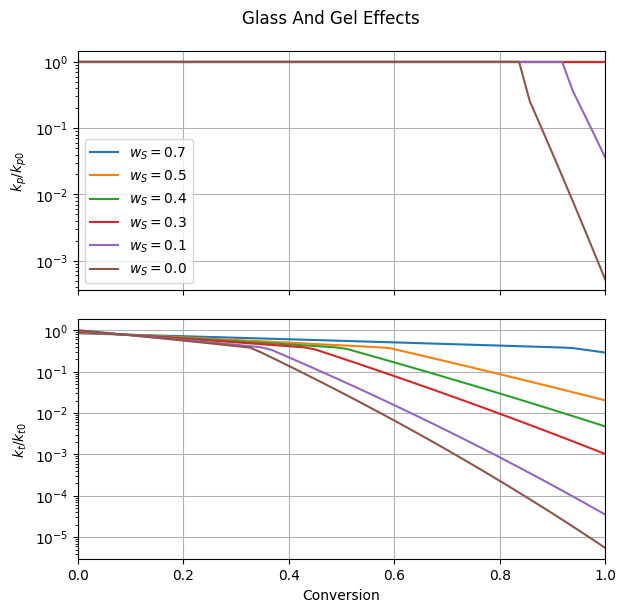

In [4]:
fig1, ax = plt.subplots(2, 1, sharex=True, figsize=(6, 6))
fig1.suptitle("Glass and gel effects".title())
fig1.tight_layout()

T = 86. # C

X_M = np.linspace(0., 1., 50)

for w_S in [0.7, 0.5, 0.4, 0.3, 0.1, 0.0]:
    gp, gt = diffusional_limitations(X_M, w_S, T, params)

    ax[0].plot(X_M, gp, label=rf"$w_S={w_S:.1f}$")
    ax[1].plot(X_M, gt)

ax[0].set_ylabel(r"$k_p/k_{p0}$")
ax[0].set_yscale('log')
ax[0].grid(True)
ax[0].legend(loc='best')

ax[1].set_ylabel(r"$k_t/k_{t0}$")
ax[1].set_yscale('log')
ax[1].grid(True)

ax[-1].set_xlabel("Conversion")
ax[-1].set_xlim(0., 1.)

The gel effect is already quite significant for mixtures with 50 wt% monomer. In contrast, the glass effect only becomes significant under (or near) bulk polymerization conditions. What is the reason for this?

## Steady-State Solutions

We will begin by implementing helper functions to describe the temperature dependence of the rate coefficients and the average density of the reaction mixture.

In [5]:
def arrhenius(T: float, k0: float, E: float, T0: float) -> float:
    """Arrhenius equation.

    Parameters
    ----------
    T : float
        Temperature (°C).
    k0 : float
        Value of rate coefficient at `T0` (#/s).
    E : float
        Energy of activation (J/mol).
    T0 : float
        Reference temperature (°C).

    Returns
    -------
    float
        Value of rate coefficient at `T`.
    """
    R = 8.314  # J/(mol.K)
    return k0 * np.exp(-E / R * (1/(273.15 + T) - 1/(273.15 + T0)))

In [6]:
def density_mixture(X_M: float, w_S: float, T: float, params: dict) -> float:
    """Density of the reaction mixture.

    Parameters
    ----------
    X_M : float
        Monomer conversion.
    w_S : float
        Solvent mass fraction.
    T : float
        Temperature (°C).
    params : dict
        Model parameters.

    Returns
    -------
    float
        Mixture density.
    """
    rho = params['rho']
    return 1/(w_S/rho['S'] + (1 - w_S)*((1 - X_M)/rho['M'] + X_M/rho['P']))

Next, we implement a function to solve the steady-state material balances. Contrary to intuition, we do not write an algorithm to determine the monomer conversion achieved at a given mean residence time; instead, we do the opposite! Can you guess why?

In [7]:
def solve_residence_time(X_M: float, w_S: float, Iin: float, T: float,
                         params: dict, tau_guess: float = 600.) -> float:
    """Find the mean residence time by solving the material balances.

    Parameters
    ----------
    X_M : float
        Monomer conversion.
    w_S : float
        Solvent mass fraction.
    Iin : float
        Initiator inlet concentration (mol/L).
    T : float
        Temperature (°C).
    params : dict
        Model parameters.
    tau_guess : float
        Initial guess for the mean residence time (s).

    Returns
    -------
    float
        Mean residence time (s).
    """

    # Rate coefficients
    f = params['kinetics']['f']
    kd = arrhenius(T, **params['kinetics']['kd'])
    kp0 = arrhenius(T, **params['kinetics']['kp0'])
    kt0 = arrhenius(T, **params['kinetics']['kt0'])

    # Diffusional limitations
    gp, gt = diffusional_limitations(X_M, w_S, T, params)
    kp = kp0*gp
    kt = kt0*gt

    # Expansion factor, ε
    rho_in = density_mixture(0., w_S, T, params)
    rho = density_mixture(X_M, w_S, T, params)
    epsilon = rho_in/rho - 1

    # Monomer inlet and outlet concentrations
    MW = params['MW']
    Min = rho_in*(1 - w_S)/MW['M']
    M = Min*(1 - X_M)/(1 + epsilon)

    # Monomer material balance
    def monomer_balance(tau):
        I = Iin/(1 + epsilon + kd*tau)
        R = np.sqrt(f*kd*I/kt)
        return Min*X_M - (kp*R*M)*tau

    sol = root_scalar(monomer_balance,
                      x0=tau_guess,
                      x1=tau_guess + 60.,
                      method='secant')

    return sol.root

We are finally ready to reproduce Figure 3 of [Schmidt & Ray (1981)].

[Schmidt & Ray (1981)]: https://doi.org/10.1016/0009-2509(81)80174-1

Text(0.5, 23.52222222222222, 'Residence time (min)')

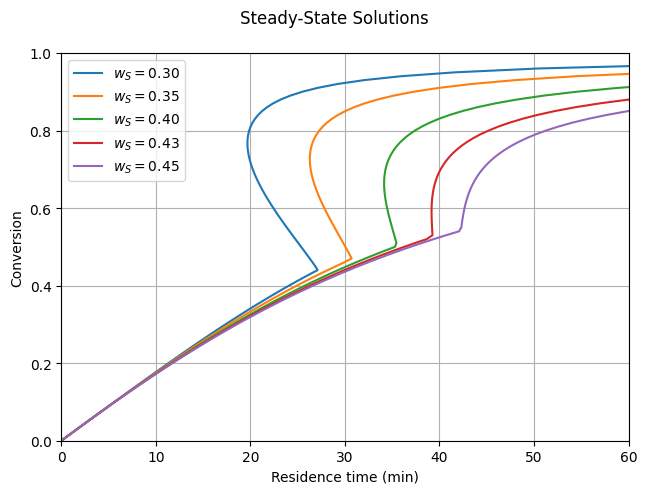

In [8]:
fig2, ax = plt.subplots(1, 1)
fig2.suptitle("Steady-state solutions".title())
fig2.tight_layout()

T = 86.      # °C
Iin = 0.032  # mol/L
tau_max = 60*60.

X_M = np.linspace(0., 1., num=101)
tau = np.empty_like(X_M)
for w_S in [0.3, 0.35, 0.4, 0.43, 0.45]:
    tau_guess = 60.
    tau[:] = np.nan
    for i in range(X_M.size):
        tau[i] = solve_residence_time(X_M[i], w_S, Iin, T, params, tau_guess)
        tau_guess = tau[i]
        if tau[i] > tau_max:
            break
    notnan = ~np.isnan(tau)
    ax.plot(tau[notnan]/60, X_M[notnan], label=rf"$w_S={w_S:.2f}$")

ax.grid(True)
ax.legend(loc='best')
ax.set_ylabel("Conversion")
ax.set_ylim(0., 1.)
ax.set_xlim(0., tau_max/60)
ax.set_xlabel("Residence time (min)")

At this temperature, multiple steady states appear for solvent contents below approximately 43 wt%. Feel free to play with the reaction conditions.

## Questions/Extras

1. Describe what happens as the mean residence time is progressively increased from 0 to 60 minutes at 30 wt% solvent.
2. Describe what happens as the mean residence time is changed in the opposite direction.
3. What happens if the system is (magically) placed in the middle steady-state solution?